In [4]:
from simcore_tools import SpecReader, PositReader
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from pathlib import Path
from importlib import reload
import yaml
import pandas as pd

In [10]:
spec_path = 'data/crossing_analysis'

# zero temperature files
t0_files = sorted(list(Path(spec_path).glob("*t0*dr30*filament_generic*.spec")))

# finite temperature files -- batched in groups of 3
tf_files = sorted(list(Path(spec_path).glob("*dr30*r00*filament_generic*.spec")))
tf_files = np.array(tf_files).reshape(len(tf_files)//3, 3)

In [11]:
def check_if_crossed(file):
    """Check whether filaments in spec file crossed barrier at x=100
    
    Returns:
        (float): Filament length
        (float): Persistence length
        (float): Bond length
        (float): Driving factor
        (ndarray, float): Incoming angles of filaments
        (ndarray, bool): Boolean array, True if the filament crossed the barrier
        
    """
    sreader = spec_reader(file)
    sreader.make_human_readable()
    params, specs = sreader.get_params_specs()
    persistence_length = params.persistence_length.iloc[0]
    length = params.length.iloc[0]
    bond_length = params.bond_length.iloc[0]
    n_sites = params.n_sites.iloc[0]
    heads_x = specs.iloc[:, 3*(n_sites-1)::3*n_sites]
    heads_y = specs.iloc[:, 3*n_sites-2::3*n_sites]
    tails_x = specs.iloc[:, 0::3*n_sites]
    tails_y = specs.iloc[:, 1::3*n_sites]
    angles = np.round(np.arctan((heads_y.iloc[0].values - tails_y.iloc[0].values) / 
                                (heads_x.iloc[0].values - tails_x.iloc[0].values)), decimals=2)
    crossed = (tails_x.iloc[-1] > 100).values
    param_file = Path(file.parent, file.name.rpartition("filament_generic")[0] + "params.yaml")
    try:
        with open(param_file, 'r') as pfile:
            yaml_params = yaml.safe_load(pfile)
            epsilon = yaml_params['soft_potential_mag']
            driving = yaml_params['filament'][0]['driving_factor']
    except Exception as e:
        print("Failed to read file ", param_file)
        raise e
    #sreader.rm_human_readable()
    return length, persistence_length, bond_length, epsilon, driving, angles, crossed

In [12]:
def calculate_p_cross_finite_temp(tf_files):
    """Calculate crossing probabilities for finite temperature sims with multiple runs"""
    lps = []
    eps = []
    tots = []
    errs = []
    assert tf_files.size > tf_files.shape[0]
    for variation in tf_files:
        crossings = []
        for run in variation:
            l, pl, bl, ep, dr, angles, crossed = check_if_crossed(run)
            crossings.append(crossed)
        crossings=np.array(crossings).astype(int)
        ncols = crossings.shape[1]
        fold = np.r_[crossings[:, :ncols//2], crossings[::-1][:, :ncols//2]]
        if ncols%2 != 0:
            fold = np.c_[fold, np.r_[crossings[:, ncols//2], crossings[:, ncols//2]]]
        total = fold.mean()
        total_err = fold.std()/np.sqrt(fold.size)
        fold_mean = fold.mean(axis=0)
        fold_err = fold.std(axis=0)/np.sqrt(fold.shape[1])
        fold = np.c_[angles[:fold_mean.shape[0]], fold_mean, fold_err]
        np.save(
            Path(run.parent, 'cross_prob_dr{:02d}_lp{:03d}_eps{:03d}'.format(int(dr), int(pl/l), ep)),
            fold
        )
        lps.append(pl)
        eps.append(ep)
        tots.append(total)
        errs.append(total_err)
    result = np.array([lps, eps, tots, errs])
    np.save(Path(run.parent, 'cross_prob_totals_dr{:02d}'.format(int(dr))), result)
    
    
def calculate_p_cross_zero_temp(t0_files):
    """Calculate crossing probabilities for zero temperature sims with one run each"""
    lps = []
    eps = []
    tots = []
    errs = []
    for run in t0_files:
        l, pl, bl, ep, dr, angles, crossings = check_if_crossed(run)
        crossings = crossings.astype(int)
        ncols = crossings.shape[0]
        assert (crossings[:ncols//2] == crossings[::-1][:ncols//2]).all()
        if ncols%2 == 0:
            fold = crossings[:ncols//2]
        else:
            fold = crossings[:ncols//2 + 1]
        total = fold.mean()
        total_err = fold.std()/np.sqrt(fold.size)
        fold = np.c_[angles[:fold_mean.shape[0]], fold]
        np.save(Path(run.parent, 'cross_prob_t0_dr{:02d}_lp{:03d}_eps{:03d}'.format(int(dr), int(pl/l), ep)), fold)
        lps.append(pl)
        eps.append(ep)
        tots.append(total)
        errs.append(total_err)
    result = np.array([lps, eps, tots, errs])
    np.save(Path(run.parent, 'cross_prob_totals_t0_dr{:02d}'.format(int(dr))), result)

In [13]:
def plot_p_cross_totals(fname):
    """Expects fname to be a .npy file (str or Path) with 4 rows"""
    fname = Path(fname)
    result = np.load(fname)
    df = pd.DataFrame(result.transpose(), columns=['lp', 'eps', 'Px', 'Pxerr'])
    table = df.pivot('eps', 'lp', values='Px')

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    img = ax.imshow(table.values, origin='lower', vmin=0, vmax=1)
    def yfunc(a, b):
        if a >= 0 and a <= 4:
            return table.index[a]
        else:
            return a
    def xfunc(a, b):
        if a >= 0 and a <= 12:
            return table.columns[a]/60
        else:
            return a
    ax.yaxis.set_major_formatter(FuncFormatter(yfunc))
    ax.xaxis.set_major_formatter(FuncFormatter(xfunc))
    ax.set_xlabel("$L_p/L$", fontsize=20)
    ax.set_ylabel("$\epsilon$", fontsize=24)
    title = "Probability of two randomly-oriented filaments crossing upon collision"
    if "_t0_" in fname.name:
        title = title + ", $T=0$"
    ax.set_title(title, fontsize=14)
    cbar = plt.colorbar(img, orientation='horizontal')
    cbar.ax.set_xlabel("$P_{cross}$", fontsize=20)
    plt.savefig(fname.stem + ".png")
    plt.show()

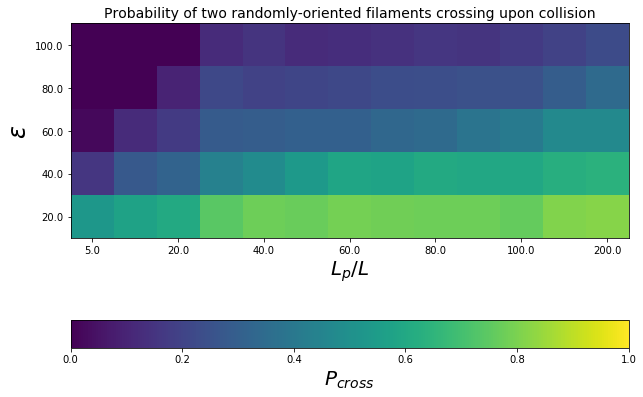

In [14]:
fname = Path(spec_path, 'cross_prob_totals_dr30.npy')
plot_p_cross_totals(fname)

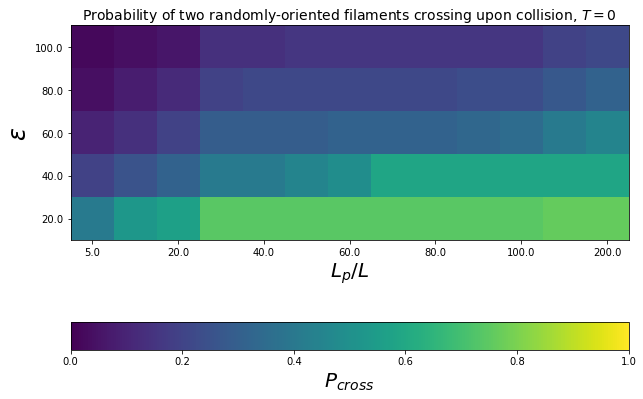

In [15]:
fname = Path(spec_path, 'cross_prob_totals_t0_dr30.npy')
plot_p_cross_totals(fname)

In [113]:
eps = 100
eps_files = sorted(list(Path(spec_path).glob("cross_prob_dr30_lp*_eps{:03d}*npy".format(eps))))

In [114]:
eps_files

[PosixPath('cross_prob_dr30_lp005_eps100.npy'),
 PosixPath('cross_prob_dr30_lp010_eps100.npy'),
 PosixPath('cross_prob_dr30_lp020_eps100.npy'),
 PosixPath('cross_prob_dr30_lp030_eps100.npy'),
 PosixPath('cross_prob_dr30_lp040_eps100.npy'),
 PosixPath('cross_prob_dr30_lp050_eps100.npy'),
 PosixPath('cross_prob_dr30_lp060_eps100.npy'),
 PosixPath('cross_prob_dr30_lp070_eps100.npy'),
 PosixPath('cross_prob_dr30_lp080_eps100.npy'),
 PosixPath('cross_prob_dr30_lp090_eps100.npy'),
 PosixPath('cross_prob_dr30_lp100_eps100.npy'),
 PosixPath('cross_prob_dr30_lp150_eps100.npy'),
 PosixPath('cross_prob_dr30_lp200_eps100.npy')]

In [17]:
cross_probs = np.load(fname)

In [19]:
result = np.load(fname)
df = pd.DataFrame(result.transpose(), columns=['lp', 'eps', 'Px', 'Pxerr'])

In [21]:
df.lp = df.lp/60

In [57]:
exp_x = [0, 0.05, 0.1, 0.15, 0.2, 0.3]
exp_y = [0.22, 0.46, 0.53, 0.71, 0.69, 0.7]

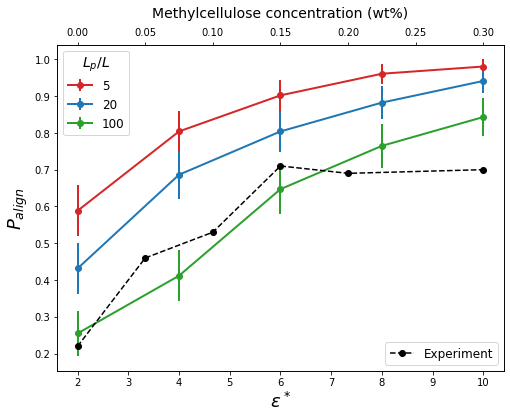

In [96]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
lps = [5, 20, 100]
colors = ['tab:red', 'tab:blue', 'tab:green']
for lp, c in zip(lps, colors):
    tmpdf = df[df.lp == lp]
    ax.errorbar(tmpdf.eps/10, 1-tmpdf.Px, yerr=tmpdf.Pxerr, fmt='-o', color=c, label=lp, linewidth=2)
ax.legend(title=r'$L_p/L$', loc=0, fontsize=12, title_fontsize=14)
ax.set_ylabel(r'$P_{align}$', fontsize=18)
ax.set_xlabel(r'$\epsilon^*$', fontsize=18)
ax2 = plt.twiny(ax)
ax2.plot(exp_x, exp_y, 'k--o', label='Experiment')
ax2.set_xlabel('Methylcellulose concentration (wt%)', fontsize=14, labelpad=10)
ax2.legend(loc='lower right', fontsize=12)
ax.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
fig.savefig("align_prob_new.png", dpi=600)
plt.show()

In [115]:
pcross = []
lps = []
for file in eps_files:
    array = np.load(file)
    angles = array[:, 0]
    probs = array[:, 1]
    pcross.append(probs)
    lp = int(file.name.partition('lp')[-1][:3])
    lps.append(lp)
pcross = np.array(pcross)

In [116]:
df = pd.DataFrame(pcross, index=lps, columns=angles)

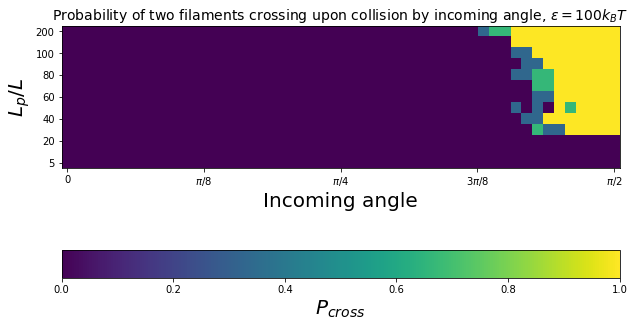

In [117]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
img = ax.imshow(df.values, origin='lower', vmin=0, vmax=1)
def yfunc(a, b):
    try:
        return df.index[a]
    except Exception:
        return a
def xfunc(a, b):
    vals = ['0', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$']
    try:
        return vals[b]
    except Exception:
        return a
ax.yaxis.set_major_formatter(FuncFormatter(yfunc))
ax.xaxis.set_ticks(np.linspace(0, df.shape[1]-1, 5))
ax.xaxis.set_major_formatter(FuncFormatter(xfunc))
ax.set_ylabel("$L_p/L$", fontsize=20)
ax.set_xlabel("Incoming angle", fontsize=20)
title = "Probability of two filaments crossing upon collision by incoming angle, $\epsilon={}k_BT$".format(eps)
#if "_t0_" in fname.name:
#    title = title + ", $T=0$"
ax.set_title(title, fontsize=14)
cbar = plt.colorbar(img, orientation='horizontal')
cbar.ax.set_xlabel("$P_{cross}$", fontsize=20)
plt.savefig("cross_prob_by_angle_dr30_eps{:03d}.png".format(eps))
plt.show()

In [80]:
np.linspace(0, df.shape[1]-1, 8)


(8,)

In [10]:
# t0_files = sorted(list(Path(spec_path).glob("crossing_analysis*t0*params.yaml")))
# t0_files = [file for file in t0_files if 'dr30' not in file.name]

# def check_driving(file):
#     with open(file, 'r') as f:
#         params = yaml.safe_load(f)
#         dr = params['filament'][0]['driving_factor']
#         if int(dr) == 30:
#             return False
#         elif int(dr) == 3:
#             return True
#     raise RuntimeError("Did not find expected values of driving in parameter file: {}".format(file))
    
# t0_files = [file for file in t0_files if check_driving(file)]

In [11]:
# calculate_p_cross_zero_temp(t0_files)

In [12]:
# fname = Path(spec_path, 'cross_prob_totals_dr03.npy')
# plot_p_cross_totals(fname)